In [1]:
from torch import nn, optim
from torch.utils.data import dataset, DataLoader
import torch
import numpy as np
import matplotlib.pyplot as plt
import control


class FCnet(nn.Module):

    def __init__(self, input_size, output_size, n_layers, layer_size):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_size, layer_size)])
        self.layers.extend(nn.Linear(layer_size, layer_size) for _ in range(n_layers - 2))
        self.layers.append(nn.Linear(layer_size, output_size))
        self.layer_size = layer_size
        for layer in self.layers:
            nn.init.xavier_uniform_(layer.weight, gain=1)
        self.input_size = input_size
        self.layer_size = layer_size
        self.tanh = nn.Hardtanh(min_val=-1, max_val=1)

    def forward(self, x):
        y = self.tanh(self.layers[0](x))
        for i in range(1, len(self.layers)):
            y = self.tanh(self.layers[i](y))
        return y


def train(model, epochs, train_loader, loss):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        losses = []
        for x, y in train_loader:
            prediction = model(x)
            loss_batch = loss(prediction, y)
            losses.append(loss_batch.item())
            optimizer.zero_grad()
            loss_batch.backward()
            optimizer.step()
        print('epoch {e}, mse {m}'.format(e=epoch, m=np.mean(losses)))

def test(model, test_loader, loss):
    losses = []
    for x, y in test_loader:
        prediction = model(x)
        loss_batch = loss(prediction, y)
        losses.append(loss_batch.item())
    return np.mean(losses)

In [2]:
system = control.TransferFunction(np.array([1, 0]), np.array([1, -7/12, 1/4, -1/24]), 1)

In [3]:
def color_gen():
    colors = ['green', 'blue', 'red']
    i = 0
    while True:
        yield colors[i]
        i += 1
        i = i % len(colors)


def plot_discrete_output(file_name=None, **kwargs):
    for elem in kwargs.keys():
        if type(kwargs[elem]) == torch.Tensor:
            kwargs[elem] = kwargs[elem].detach().numpy().ravel()
    data_dict = kwargs
    assert len(set((elem.shape for elem in data_dict.values()))) == 1
    fig, ax = plt.subplots()
    for label, data, color in zip(data_dict.keys(), data_dict.values(), color_gen()):
        # ax.set_ylim((-0.5, 0.5))
        ax.set_xticks(np.arange(data.shape[0]))
        ax.set_xlabel('Момент времени', fontsize=15)
        ax.set_ylabel('Выход системы', fontsize=15)
        ax.scatter(x=np.arange(data.shape[0]), y=data, label=label, color=color)
        
    ax.legend(fontsize=15, loc="upper right")
    ax.grid()
    counter = 0
    for tic in ax.xaxis.get_major_ticks():
        if counter % 10 != 0:
            tic.tick1On = tic.tick2On = False
            tic.label1On = tic.label2On = False
        counter += 1
    fig.set_size_inches((10, 10))
    if file_name is None:
        plt.show()
    else:
        plt.savefig(file_name)

In [74]:
def func(impact_time):
    return np.sin(np.arange(impact_time) * 0.1) / 2

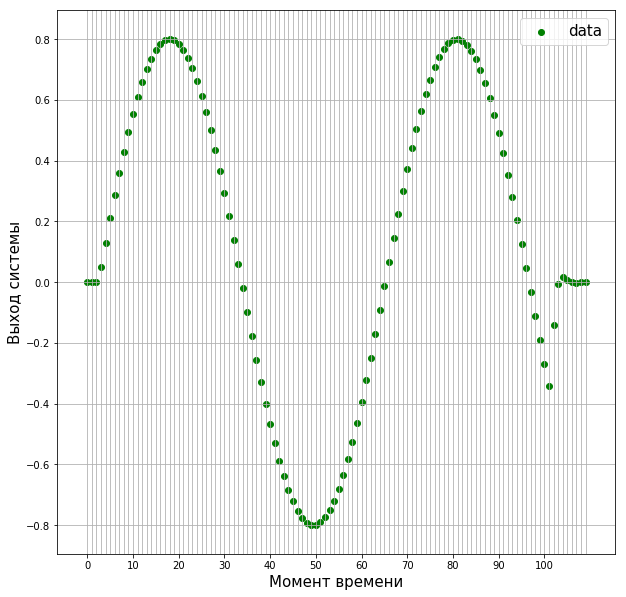

In [75]:
impact_time = 100
cooldown_time = 10 
U = np.concatenate((func(impact_time), np.zeros(cooldown_time)))
output = control.forced_response(system, T=np.arange(impact_time + cooldown_time), U=U)[1]
plot_discrete_output(
    file_name='tmp.png',
    data=output[0]
)

In [76]:
control.margin(system)

(0.625, 36.67860882036618, 0.0, 1.036960862501573)

### Проверка на случайных синусоидах с различным периодом (амплитуда фиксирована)

In [4]:
class ControlDataset(dataset.Dataset):
    
    def __init__(self, global_u, global_y):
        assert len(global_u) == len(global_y)
        self.global_u = global_u
        self.global_y = global_y
        
    def __getitem__(self, index):
        return self.global_u[index], self.global_y[index]
    
    def __len__(self):
        return len(self.global_u)


def generate_data(control_sys, impact_time, cooldown_time, n_samples, input_func):
    total_time = impact_time + cooldown_time
    global_u = [
        np.concatenate((input_func(impact_time), np.zeros(cooldown_time)))
        for _ in range(n_samples)
    ]
    global_y = [control.forced_response(control_sys, T=np.arange(total_time), U=u)[1] for u in global_u]
    global_u = [torch.tensor(elem.ravel(), requires_grad=True).float() for elem in global_u]
    global_y = [torch.tensor(elem.ravel(), requires_grad=True).float() for elem in global_y]
    
    return ControlDataset(global_u, global_y)

In [72]:
train_dataset = generate_data(
    control_sys=system,
    impact_time=90,
    cooldown_time=10,
    n_samples=1000,
    input_func=lambda x: np.sin(np.arange(x) * np.random.uniform(low=0.05, high=0.1)) / 2
)

In [73]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

In [74]:
model = FCnet(input_size=train_dataset[0][0].size()[0], output_size=train_dataset[0][1].size()[0], n_layers=5, layer_size=50)

In [75]:
train(model, 100, train_dataloader, nn.MSELoss())

epoch 0, mse 0.057646847054129466
epoch 1, mse 0.0015963246586034074
epoch 2, mse 0.0007493811697349884
epoch 3, mse 0.00047861173676210455
epoch 4, mse 0.0003190204160637222
epoch 5, mse 0.00020233857801940758
epoch 6, mse 0.00012005345710349503
epoch 7, mse 7.580110210255952e-05
epoch 8, mse 5.6261041900143025e-05
epoch 9, mse 5.6597711918584536e-05
epoch 10, mse 3.4254179809067864e-05
epoch 11, mse 2.7327291700203205e-05
epoch 12, mse 2.625964320031926e-05
epoch 13, mse 2.7202669725738817e-05
epoch 14, mse 1.9473959391689276e-05
epoch 15, mse 2.139696762242238e-05
epoch 16, mse 4.4568333241841176e-05
epoch 17, mse 4.526129951955227e-05
epoch 18, mse 1.6965536087809596e-05
epoch 19, mse 1.2144317893216793e-05
epoch 20, mse 1.2319859629315032e-05
epoch 21, mse 8.425675438957114e-05
epoch 22, mse 6.172283173782488e-05
epoch 23, mse 3.385709609119658e-05
epoch 24, mse 3.4038796802633444e-05
epoch 25, mse 1.505817222096084e-05
epoch 26, mse 0.0001821049797354135
epoch 27, mse 5.237579915

In [89]:
test_dataset = generate_data(
    control_sys=system,
    impact_time=90,
    cooldown_time=10,
    n_samples=1000,
    input_func=lambda x: np.sin(np.arange(x) * np.random.uniform(low=0.05, high=0.1)) / 2
)

In [90]:
test_dataloader = DataLoader(test_dataset, batch_size=1)

среднее MSE для одного сигнала на сгенерированной тестовой выборке

In [91]:
test(model, test_dataloader, nn.MSELoss())

1.1196042208666767e-05

In [92]:
test_dataset[0]

(tensor([ 0.0000,  0.0265,  0.0529,  0.0792,  0.1052,  0.1310,  0.1563,  0.1813,
          0.2057,  0.2296,  0.2528,  0.2753,  0.2970,  0.3179,  0.3379,  0.3569,
          0.3750,  0.3920,  0.4079,  0.4226,  0.4362,  0.4485,  0.4596,  0.4694,
          0.4778,  0.4850,  0.4907,  0.4951,  0.4981,  0.4997,  0.4999,  0.4987,
          0.4961,  0.4921,  0.4867,  0.4799,  0.4718,  0.4624,  0.4517,  0.4397,
          0.4265,  0.4120,  0.3965,  0.3798,  0.3620,  0.3432,  0.3235,  0.3028,
          0.2813,  0.2590,  0.2360,  0.2123,  0.1881,  0.1632,  0.1380,  0.1123,
          0.0864,  0.0601,  0.0338,  0.0073, -0.0192, -0.0456, -0.0720, -0.0981,
         -0.1239, -0.1494, -0.1745, -0.1990, -0.2231, -0.2464, -0.2692, -0.2911,
         -0.3122, -0.3325, -0.3518, -0.3701, -0.3874, -0.4036, -0.4187, -0.4326,
         -0.4452, -0.4567, -0.4668, -0.4756, -0.4831, -0.4893, -0.4941, -0.4974,
         -0.4994, -0.5000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  

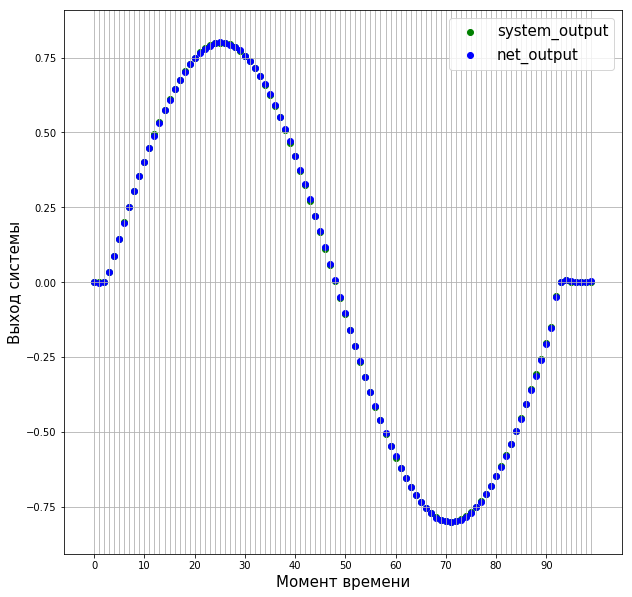

In [93]:
plot_discrete_output(
    system_output=test_dataset[2][1],
    net_output=model(test_dataset[2][0]),
    file_name='fcnet_prediction.png'
)

### shifted

In [94]:
test_dataset = generate_data(
    control_sys=system,
    impact_time=90,
    cooldown_time=10,
    n_samples=1000,
    input_func=lambda x: np.sin(np.arange(x) * np.random.uniform(low=0.1, high=0.2)) / 2
)

In [95]:
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [96]:
test(model, test_dataloader, nn.MSELoss())

0.1584131634632213

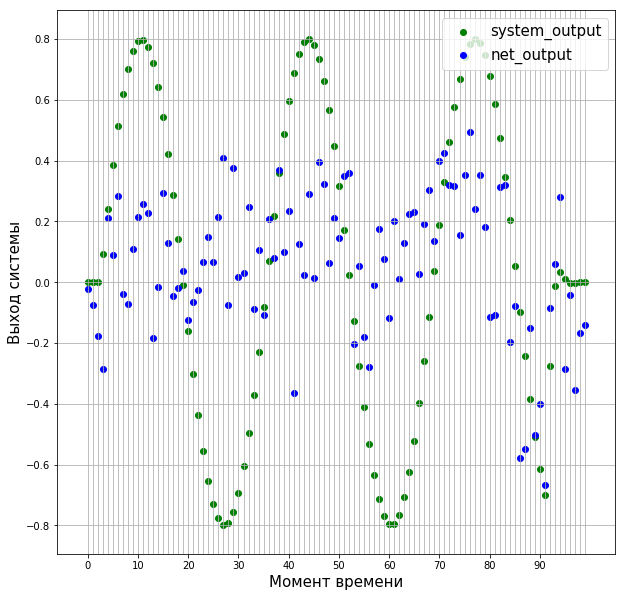

In [97]:
plot_discrete_output(
    system_output=test_dataset[2][1],
    net_output=model(test_dataset[2][0]),
    file_name='fcnet_prediction_shifted.png'
)

### Высокая частота

In [71]:
train_dataset = generate_data(
    control_sys=system,
    impact_time=100,
    cooldown_time=10,
    n_samples=1000,
    input_func=lambda x: np.sin(np.arange(x) * np.random.uniform(low=0.3, high=0.4)) / 2
)

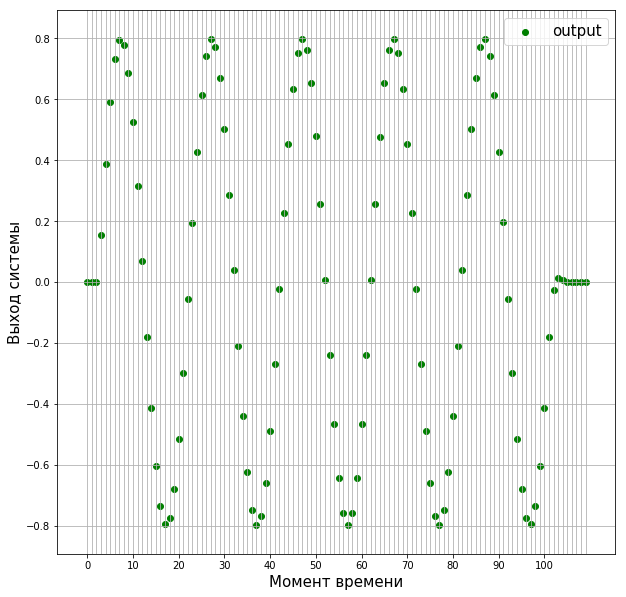

In [38]:
plot_discrete_output(output=train_dataset[0][1])

In [39]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

In [40]:
model = FCnet(input_size=train_dataset[0][0].size()[0], output_size=train_dataset[0][1].size()[0], n_layers=5, layer_size=50)

In [41]:
train(model, 100, train_dataloader, nn.MSELoss())

epoch 0, mse 0.07310554970987142
epoch 1, mse 0.0031472450599540026
epoch 2, mse 0.0012257686056545937
epoch 3, mse 0.0003805554129939992
epoch 4, mse 0.0002810585245606489
epoch 5, mse 0.0002374676749604987
epoch 6, mse 0.0001927536149014486
epoch 7, mse 0.0001591472473955946
epoch 8, mse 0.00012304556054004934
epoch 9, mse 0.0001178556202648906
epoch 10, mse 0.00010247875870845746
epoch 11, mse 7.458531705196947e-05
epoch 12, mse 4.7200726949085945e-05
epoch 13, mse 5.356770954676904e-05
epoch 14, mse 3.2066168259916594e-05
epoch 15, mse 4.851009456615429e-05
epoch 16, mse 3.791933108004741e-05
epoch 17, mse 5.326191945641767e-05
epoch 18, mse 9.347229042759864e-05
epoch 19, mse 0.00011156787622894626
epoch 20, mse 4.3355990001145984e-05
epoch 21, mse 0.00014012681829626673
epoch 22, mse 0.0003058499759572442
epoch 23, mse 4.381321654364001e-05
epoch 24, mse 2.5073265951505164e-05
epoch 25, mse 4.841848205614952e-05
epoch 26, mse 0.0002737137241274468
epoch 27, mse 0.0005724774503323

In [59]:
test_dataset = generate_data(
    control_sys=system,
    impact_time=100,
    cooldown_time=10,
    n_samples=1000,
    input_func=lambda x: np.sin(np.arange(x) * np.random.uniform(low=0.2, high=0.3)) / 2
)

In [60]:
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [61]:
test(model, test_dataloader, nn.MSELoss())

RuntimeError: shape '[-1, 5, 20]' is invalid for input of size 110

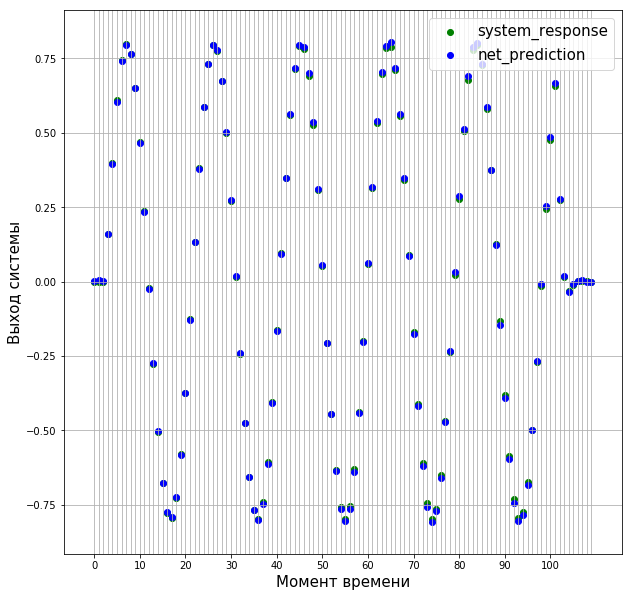

In [53]:
plot_discrete_output(
    system_response=test_dataset[3][1],
    net_prediction=model(test_dataset[3][0]),
    file_name='fcnet_prediction.png'
)

# RNN

In [118]:
class ControlRNN(nn.Module):
    def __init__(self, window_size, layer_input_size, hidden_size, output_size, num_layers=2):
        assert window_size % layer_input_size == 0
        super().__init__()
        self.reccurency = window_size // layer_input_size
        self.layer_input_size = layer_input_size
        
        self.layers = nn.ModuleList()
        self.layers.append(
            nn.LSTM(
                input_size=layer_input_size,
                hidden_size=hidden_size,
                num_layers=num_layers
            )
        )
        self.layers.append(nn.Linear(hidden_size, output_size))

    def forward(self, window_data):
        hidden, _ = self.layers[0](window_data.view(-1, self.reccurency, self.layer_input_size).transpose(0, 1))
        last_hidden = hidden[-1, :, :]
        return self.layers[1](last_hidden)

In [119]:
def generate_data_for_rnn(
    control_sys,
    impact_time,
    n_signals,
    n_samples_per_signal,
    sample_u_size,
    sample_response_size,
    u_signal_generation_func
):
    samples_u = list()
    samples_response = list()
    for _ in range(n_signals):
        u = u_signal_generation_func(impact_time)
        response = control.forced_response(control_sys, T=np.arange(impact_time), U=u)[1][0]
        for _ in range(n_samples_per_signal):
            start = np.random.randint(
                low=0,
                high=impact_time - sample_u_size
            )
            fin = start + sample_u_size
            samples_u.append(torch.tensor(u[start: fin], requires_grad=True).float())
            samples_response.append(torch.tensor(response[fin - sample_response_size: fin], requires_grad=True).float())
    
    return ControlDataset(samples_u, samples_response)

In [120]:
train_dataset = generate_data_for_rnn(
    control_sys=system,
    impact_time=1000,
    n_signals=100,
    n_samples_per_signal=10,
    sample_u_size=100,
    sample_response_size=20,
    u_signal_generation_func=lambda x: np.sin(np.arange(x) * np.random.uniform(low=0.05, high=0.1)) / 2
)

In [121]:
model = ControlRNN(
    window_size=100, layer_input_size=20, hidden_size=50, output_size=20, num_layers=2
)

In [122]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

In [123]:
train(model, 30, train_dataloader, nn.MSELoss())

epoch 0, mse 0.15952809708658605
epoch 1, mse 0.005439666032325477
epoch 2, mse 0.0017400881822686642
epoch 3, mse 0.0007773269049357622
epoch 4, mse 0.0005171846220036969
epoch 5, mse 0.00040551848549512213
epoch 6, mse 0.00031272272957721725
epoch 7, mse 0.0002773298913234612
epoch 8, mse 0.000232957018451998
epoch 9, mse 0.00021498492249520497
epoch 10, mse 0.00016754073963966222
epoch 11, mse 0.00014389444411790463
epoch 12, mse 0.00012570883005537327
epoch 13, mse 0.00010375781293987529
epoch 14, mse 9.851905346295098e-05
epoch 15, mse 8.28342379827518e-05
epoch 16, mse 8.259172125690383e-05
epoch 17, mse 8.620322940259939e-05
epoch 18, mse 6.498091148387176e-05
epoch 19, mse 6.38535443067667e-05
epoch 20, mse 5.8980206486012324e-05
epoch 21, mse 5.093896457765368e-05
epoch 22, mse 5.368158039345872e-05
epoch 23, mse 5.093620675324928e-05
epoch 24, mse 0.00011835084951599129
epoch 25, mse 4.812833898540703e-05
epoch 26, mse 5.4127465355122694e-05
epoch 27, mse 5.1336875949345994e-

In [65]:
test_dataset = generate_data_for_rnn(
    control_sys=system,
    impact_time=1000,
    n_signals=100,
    n_samples_per_signal=10,
    sample_u_size=100,
    sample_response_size=20,
    u_signal_generation_func=lambda x: np.sin(np.arange(x) * np.random.uniform(low=0.05, high=0.1)) / 2
)

In [66]:
test(model, DataLoader(test_dataset, batch_size=10, shuffle=True), nn.MSELoss())

3.592630981074763e-05

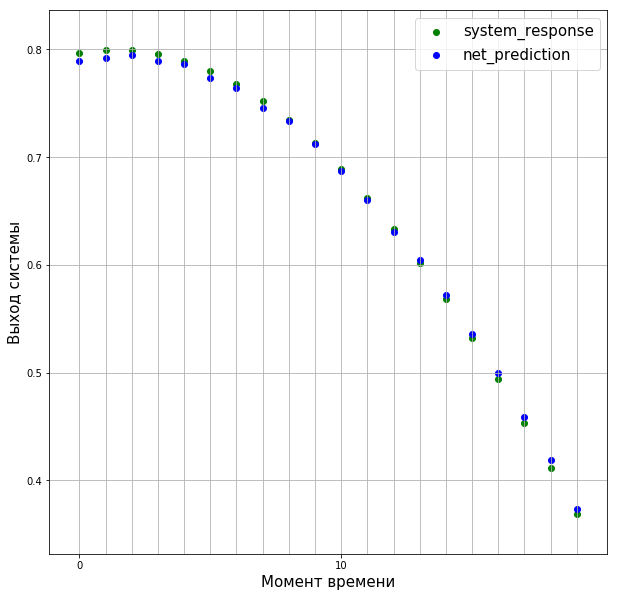

In [67]:
plot_discrete_output(
    system_response=test_dataset[1][1],
    net_prediction=model(test_dataset[1][0]),
    file_name='rnn_prediction.png'
)

### shifted

In [68]:
test_dataset = generate_data_for_rnn(
    control_sys=system,
    impact_time=1000,
    n_signals=100,
    n_samples_per_signal=10,
    sample_u_size=100,
    sample_response_size=20,
    u_signal_generation_func=lambda x: np.sin(np.arange(x) * np.random.uniform(low=0.1, high=0.2)) / 2
)

In [70]:
test(model, DataLoader(test_dataset, batch_size=10, shuffle=True), nn.MSELoss())

0.04111827832646668

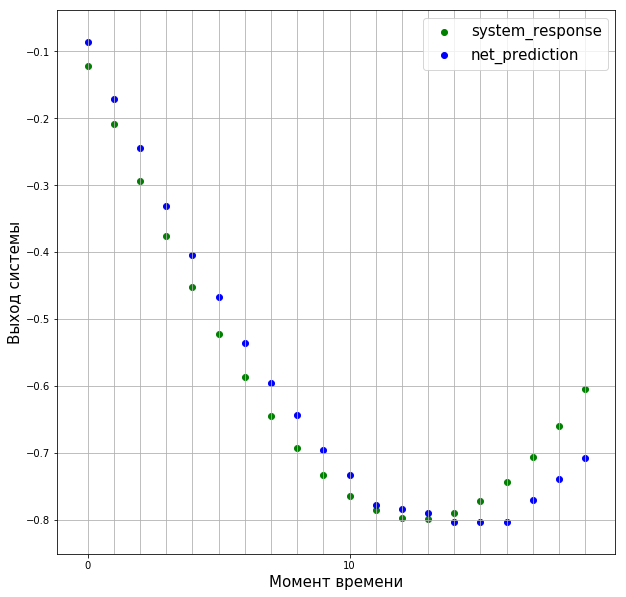

In [69]:
plot_discrete_output(
    system_response=test_dataset[1][1],
    net_prediction=model(test_dataset[1][0]),
    file_name='rnn_prediction_shifted.png'
)

### 100 secs

In [148]:
u = np.sin(np.arange(1000) * np.random.uniform(low=0.05, high=0.1)) / 2

In [149]:
prediction = np.concatenate([model(torch.tensor(u[i: i + 100], requires_grad=True).float()).detach().numpy().ravel() for i in np.arange(5) * 20])

In [150]:
prediction.shape

(100,)

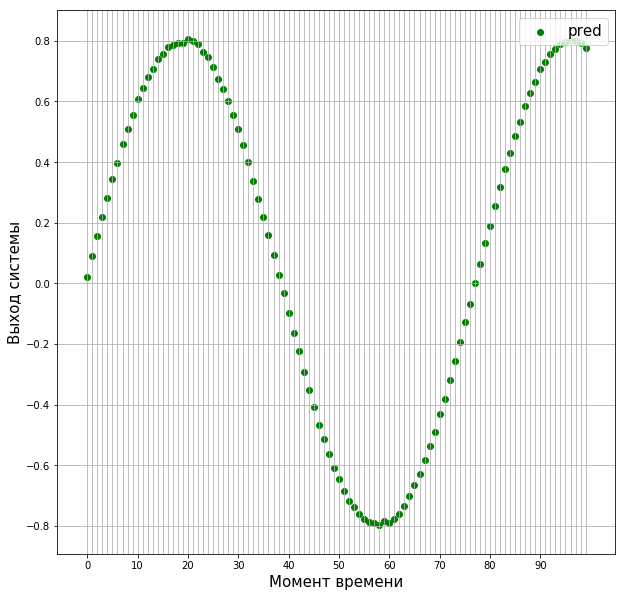

In [151]:
plot_discrete_output(
    pred=prediction
)

In [152]:
response = control.forced_response(system, T=np.arange(1000), U=u)[1][0]

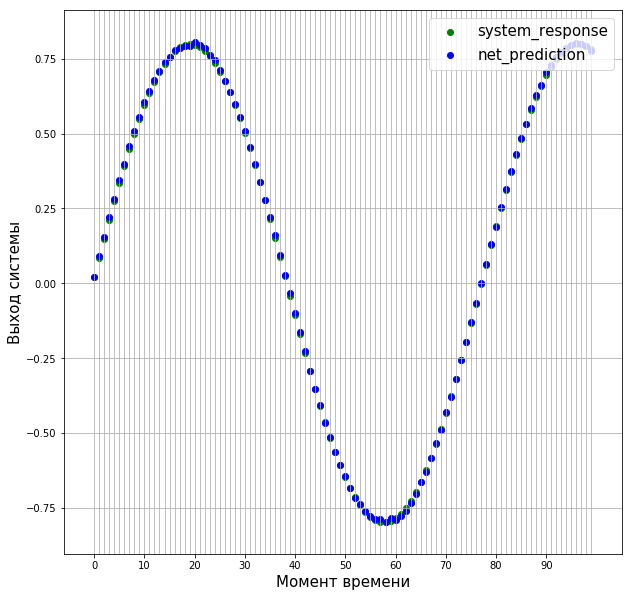

In [153]:
plot_discrete_output(
    system_response=response[80:180],
    net_prediction=prediction,
    file_name='rnn_prediction_long.png'
)

### shifted

In [154]:
u = np.sin(np.arange(1000) * np.random.uniform(low=0.1, high=0.2)) / 2

In [158]:
prediction = np.concatenate([model(torch.tensor(u[i: i + 100], requires_grad=True).float()).detach().numpy().ravel() for i in np.arange(5) * 20])

In [159]:
response = control.forced_response(system, T=np.arange(1000), U=u)[1][0]

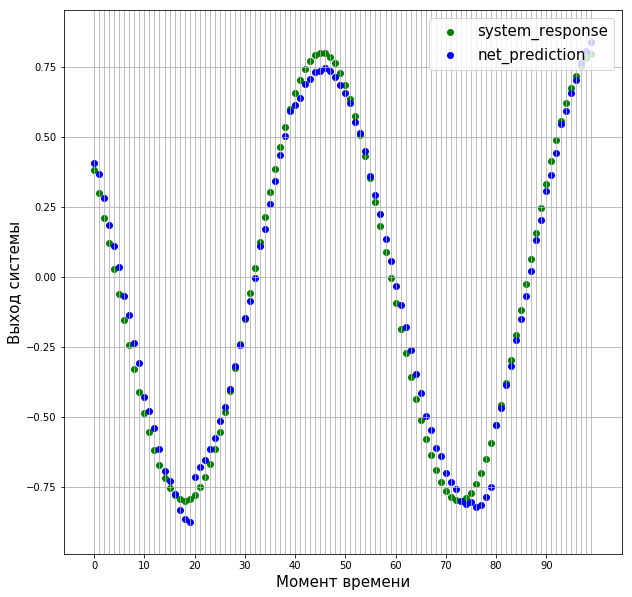

In [160]:
plot_discrete_output(
    system_response=response[80:180],
    net_prediction=prediction,
    file_name='rnn_prediction_long_shifted.png'
)